In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt



In [22]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
df = df[['v1', 'v2']]
df.columns = ['label', 'message']
df['label'] = df['label'].map({'ham': 0, 'spam': 1})


In [23]:
x = df['message']
y = df['label']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [24]:
tfidf = TfidfVectorizer(stop_words='english', max_df=0.95)
x_train_tfidf = tfidf.fit_transform(x_train)
x_test_tfidf = tfidf.transform(x_test)


In [25]:
model = MultinomialNB()
model.fit(x_train_tfidf, y_train)


MultinomialNB()

In [26]:
y_pred = model.predict(x_test_tfidf)


In [27]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9668161434977578
Confusion Matrix:
[[965   0]
 [ 37 113]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.75      0.86       150

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.96      1115



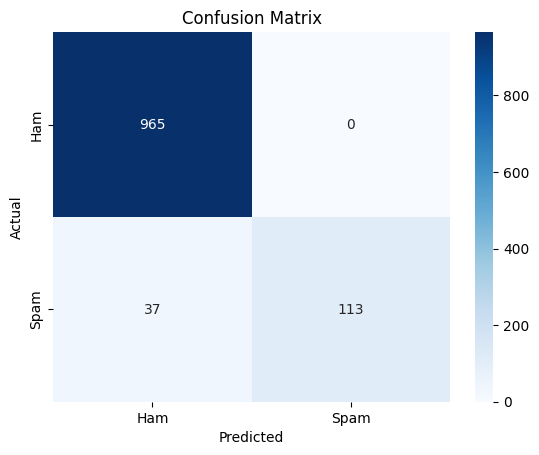

In [28]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [29]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt


In [30]:
y_probs = model.predict_proba(x_test_tfidf)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)


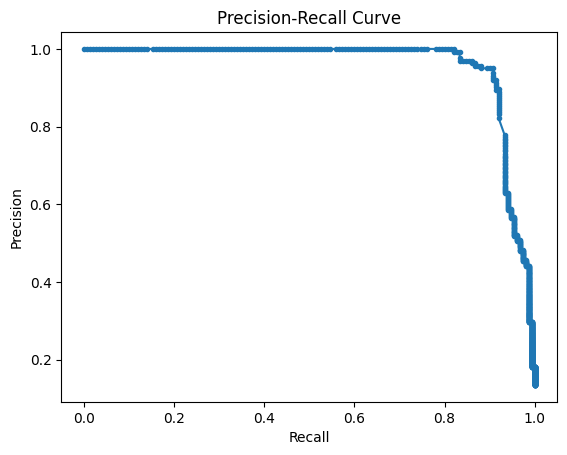

In [31]:
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [32]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

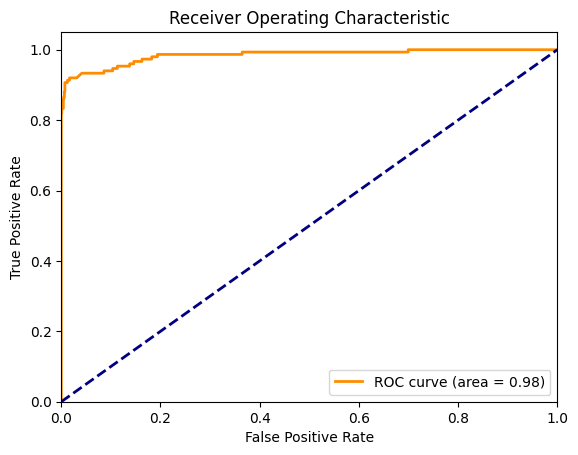

In [33]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [34]:
feature_names = tfidf.get_feature_names_out()
log_prob_spam = model.feature_log_prob_[1]
log_prob_ham = model.feature_log_prob_[0]
spam_keywords = feature_names[log_prob_spam.argsort()[-10:]]  # Top 10 spam features
ham_keywords = feature_names[log_prob_ham.argsort()[-10:]]    # Top 10 ham features

print("Top 10 spam keywords:", spam_keywords)
print("Top 10 ham keywords:", ham_keywords)

Top 10 spam keywords: ['www' 'reply' 'ur' 'prize' 'text' 'stop' 'claim' 'mobile' 'txt' 'free']
Top 10 ham keywords: ['time' 'got' 'home' 'good' 'just' 'gt' 'lt' 'come' 'll' 'ok']


In [35]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'tfidf__max_df': [0.9, 0.95, 1.0],
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # Use unigrams or bigrams
    'model__alpha': [0.1, 0.5, 1.0]  # Alpha for MultinomialNB smoothing
}


In [36]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('model', MultinomialNB())
])

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

# Output the best parameters and accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)


Best Parameters: {'model__alpha': 0.1, 'tfidf__max_df': 0.9, 'tfidf__ngram_range': (1, 2)}
Best Cross-Validation Accuracy: 0.9865370194219223


In [37]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
lr_model = LogisticRegression()

# Train the model
lr_model.fit(x_train_tfidf, y_train)

# Predict the labels
y_pred_lr = lr_model.predict(x_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))


Accuracy: 0.9524663677130045
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       965
           1       0.97      0.67      0.79       150

    accuracy                           0.95      1115
   macro avg       0.96      0.83      0.88      1115
weighted avg       0.95      0.95      0.95      1115



In [70]:
# Get the predicted probabilities
y_probs = model.predict_proba(x_test_tfidf)[:, 1]

# Set a custom threshold (e.g., 0.3 instead of 0.5)
y_pred_custom = (y_probs >= 0.3).astype(int)

# Evaluate the model
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print("Custom Threshold Accuracy:", accuracy_score(y_test, y_pred_custom))
print("Classification Report:\n", classification_report(y_test, y_pred_custom))


Confusion Matrix:
[[965   0]
 [ 37 113]]
Custom Threshold Accuracy: 0.9757847533632287
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.97      0.85      0.90       150

    accuracy                           0.98      1115
   macro avg       0.97      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



In [71]:
import joblib

# Assuming 'model' is your trained Naive Bayes model
# and 'tfidf' is your TF-IDF vectorizer

# Save the model to a file
joblib.dump(model, 'spam_classifier_model.pkl')

# Save the TF-IDF vectorizer to a file
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

In [73]:
# Load the saved model and vectorizer
model = joblib.load('spam_classifier_model.pkl')
tfidf = joblib.load('tfidf_vectorizer.pkl')
